# Predicting number of days until a Department of Buildings Complaint is inspected

#### By: Mahdi Shadkam-Farrokhi & Jeremy Ondov

## Boom's Suggestions:

- <input type="checkbox" checked>Cut at 2009</input>
- <input type="checkbox" checked>Proof seasonality</input>
- <input type="checkbox" checked>SARIMAX w/exog</input>
- <input type="checkbox">Daily is preferable</input>
- <input type="checkbox">Do pull outside daily data best</input>
- <input type="checkbox">Cap at 0 when predicting</input>

## Problem Statement
In New York City, building violations are frequently reported to the Department of Buildings(DOB), which is often initiated by a citizen. However, the length of time between the report and a response by the DOB may vary greatly depending on the location, violation type, and other factors.

We'll be using $R^2$ for model selection.

## Executive Summary
...

## Table of Contents
1. 
2. [Resources](#Resources)


## Loading libraries and data
These data were cleaned from the original source. Please see the accompanying notebook for details on the cleaning process.

In [6]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import pmdarima as pm
import statsmodels.formula.api as smf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [7]:
db = pd.read_csv('./datasets/cleaned.csv', index_col = 0, parse_dates = ["date_entered"])

In [8]:
db.head()

,complaint_number,status,date_entered,house_number,zip_code,house_street,special_district,complaint_category,unit,inspection_date,days_until_inspection
1,2193181,CLOSED,2013-12-17,573,10458,EAST FORDHAM ROAD,NOT SPECIAL,4B,SEP,2013-12-24,7
6,1265849,CLOSED,2009-09-21,429,10075,EAST 77 STREET,NOT SPECIAL,73,MAN.,2009-10-03,12
12,1404696,CLOSED,2015-09-02,21,10011,WEST 8 STREET,NOT SPECIAL,37,ERT,2015-09-03,1
13,2149422,CLOSED,2010-08-25,2075,10462,WALLACE AVENUE,NOT SPECIAL,23,ERT,2010-10-09,45
14,3312533,CLOSED,2009-07-20,819,11220,59 STREET,NOT SPECIAL,90,CITY,2009-09-15,57


## Data Cleaning

(Please see accompanying notebook)

SUMMARY OF WHAT WAS CLEANED AND WHY
- Filtered "CLOSED"
- Removed nulls
- Removed invalid dates
- Infered `days_until_inspection`
- Removed negative `days_until_inspection`

In [9]:
db["zip_code"] = db["zip_code"].map(lambda x:x.rstrip())

In [10]:
db[db["zip_code"] == "11211"].shape

(1051, 11)

In [11]:
db[db["zip_code"] == "11249"].shape

(362, 11)

### Removing Outliers

During model evaluation, we found some significant outliers, which bear consideration.

We've decided to remove these extreme observations from our training set.

In [12]:
db["days_until_inspection"].describe()

count    82136.000000
mean        87.117841
std        204.665209
min          1.000000
25%          5.000000
50%         24.000000
75%         84.000000
max       3402.000000
Name: days_until_inspection, dtype: float64

In [13]:
db.sort_values(by="days_until_inspection", ascending = False).head()

,complaint_number,status,date_entered,house_number,zip_code,house_street,special_district,complaint_category,unit,inspection_date,days_until_inspection
5770,4386626,CLOSED,2009-01-15,43-21,11103,25 AVENUE,NOT SPECIAL,45,QNS.,2018-05-10,3402
148999,1249123,CLOSED,2009-02-17,54,10009,AVENUE C,NOT SPECIAL,05,MAN.,2018-06-05,3395
24810,4397996,CLOSED,2009-04-24,97-21,11419,109 STREET,NOT SPECIAL,45,QNS.,2018-08-01,3386
252539,3300181,CLOSED,2009-04-02,271,11224,SEA BREEZE AVENUE,NOT SPECIAL,1G,EXCAV,2018-06-29,3375
59144,2127087,CLOSED,2009-03-03,462,10454,EAST 137 STREET,NOT SPECIAL,31,BRONX,2018-04-23,3338


In [14]:
db["days_until_inspection"].max() / 365 # converting days to years

9.32054794520548

We can see some extreme DOB complaints took over 10 years to be inspected!

It's hard to tell if these are erroneous or valid, since there are many cases like this.

---
During model evaluation, we found the dat associated with 2009-04-02 to have usual observations with large `days_until_inspection`

In [15]:
outlier_dates = ["2009-04-02"]
db[db["date_entered"].isin(outlier_dates)].sort_values("inspection_date", ascending = False).head()

,complaint_number,status,date_entered,house_number,zip_code,house_street,special_district,complaint_category,unit,inspection_date,days_until_inspection
252539,3300181,CLOSED,2009-04-02,271,11224,SEA BREEZE AVENUE,NOT SPECIAL,1G,EXCAV,2018-06-29,3375
13905,3300208,CLOSED,2009-04-02,294,11211,RODNEY STREET,NOT SPECIAL,1G,EXCAV,2016-12-30,2829
4262,1252769,CLOSED,2009-04-02,81,10035,EAST 125 STREET,NOT SPECIAL,1G,EXCAV,2014-08-25,1971
4262,1252769,CLOSED,2009-04-02,81,10035,EAST 125 STREET,NOT SPECIAL,1G,EXCAV,2014-08-25,1971
990378,1252808,CLOSED,2009-04-02,11,10027,WEST 125 STREET,NOT SPECIAL,1G,EXCAV,2014-07-28,1943


There may be some association with these exceptionally long inspection times and the `unit` "EXCAV".

As a threshold, we'll remove all observations above 3200 `days_until_inspection`.

In [16]:
outlier_threshold = 3200
db[db["days_until_inspection"] > outlier_threshold].shape

(13, 11)

We find 24 outlier observations, which account for about .03% of the data.

In [17]:
db = db[db["days_until_inspection"] <= outlier_threshold]

## Exploratory Data Analysis

#### Trying log transformation
Skewed distributions can sometimes be coerced to normal using the log transformation. If this is the case with our target, then we may be able to work with a linear regression or other simple model.

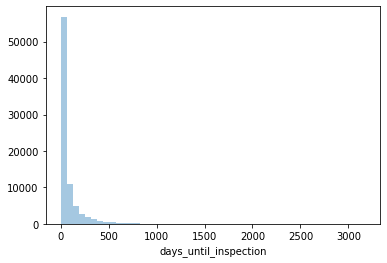

In [18]:
sns.distplot(db["days_until_inspection"], kde = False, bins = 50);

We find a heavily skewed distribution for our target variable, `days_until_inspection`, which is remniscent of an exponential or gamma distribution.

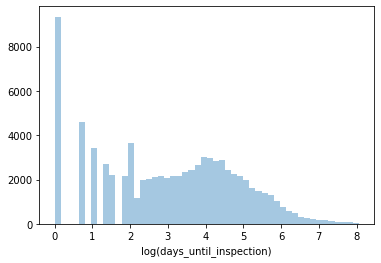

In [19]:
sns.distplot(np.log(db["days_until_inspection"]), axlabel="log(days_until_inspection)", kde = False);

Log transforming our target variable does __not__ result in a normal-looking distribution, so we will keep the target feature as is.

#### Aggregating data by various time intervals

In [20]:
db_with_time_index = db.set_index("date_entered")[["days_until_inspection"]]

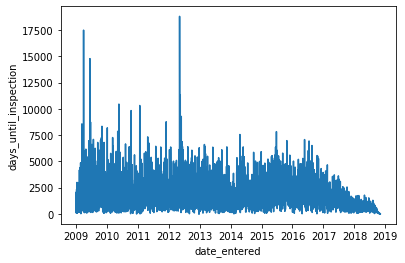

In [21]:
# by day
db_time_by_day = db_with_time_index.resample("D").sum()
sns.lineplot(y = db_time_by_day["days_until_inspection"], x = db_time_by_day.index);

We find after 2016, there appears to be a downward trend in the number of days until a complaint is inspected.

We must consider the recency of the tail end, however, since these complaints are less likely to be "CLOSED" and therefore not seen in the data.

It's difficult to tell if there's any seasonality in these data when aggregating by day.

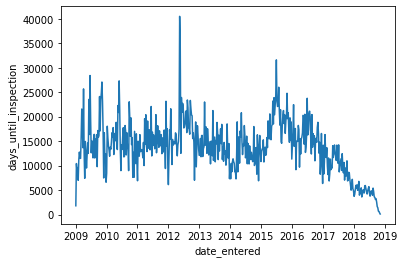

In [22]:
# by week
db_time_by_week = db_with_time_index.resample("W").sum()
sns.lineplot(y = db_time_by_week["days_until_inspection"], x = db_time_by_week.index);

It's difficult to tell if there's any seasonality in these data when aggregating by week.

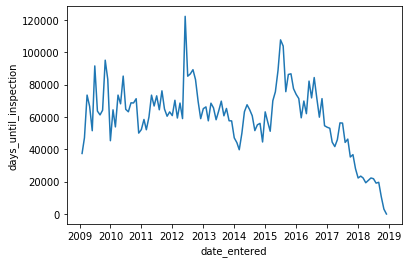

In [23]:
# by month
db_time_by_month = db_with_time_index.resample("M").sum()
sns.lineplot(y = db_time_by_month["days_until_inspection"], x = db_time_by_month.index);

There may be some seasonality by month, though it appears somewhat irregular.

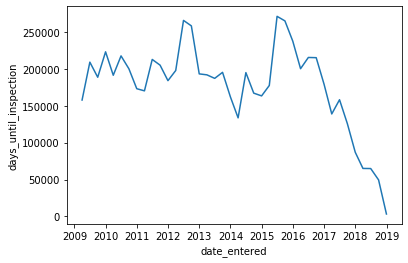

In [24]:
# by quarter
db_time_by_Q = db_with_time_index.resample("Q").sum()
sns.lineplot(y = db_time_by_Q["days_until_inspection"], x = db_time_by_Q.index);

Looking at quarterly aggregations, it's difficult to see a clear regular pattern.

---
We may want to consider testing for seasonality and using an ARIMA or SARIMAX model.

#### Testing for seasonality

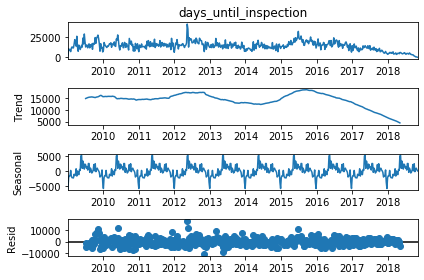

In [25]:
seasonal_decompose(db_time_by_week["days_until_inspection"]).plot()
plt.show()

After decomposing the data we find a seasonal component, which suggests a SARIMAX model may be worth exploring.

### Exploring `Special District`, `Complaint Category` , and `Unit` vs. `days_until_inspection`

In [26]:
def capitalize_words(string):
    '''Returns string with each work capitalized'''
    return " ".join([word.capitalize() for word in string.split()])

In [27]:
def aggregation_plots(db, x, y):
    '''Plots a barplot and boxplot of the given features, limited to top 10 and sorted in descending order'''
    height_per_label = .3
    total_height = len(db[y].unique()[:10]) * height_per_label
    fig, axes = plt.subplots(ncols = 2, figsize = (10, total_height + (2 if total_height< 4 else 0)))
    ax1, ax2 = axes
    
    xlabel = capitalize_words(x.replace("_"," "))
    ylabel = capitalize_words(y.replace("_"," "))
    fig.suptitle("Average {} by {}".format(xlabel,ylabel), y = 1.075)
    
    sorted_label_values = db.groupby(y)[x].agg("mean").sort_values(ascending = False)[:10]

    sns.barplot(ax = ax1, x = db[x], y = db[y], order = sorted_label_values.index)

    ax1.set_ylabel(ylabel)
    ax1.set_xlabel(xlabel)
    
    sns.boxplot(ax = ax2, x = db[x], y = db[y], order = sorted_label_values.index)    
    ax2.set_ylabel(ylabel)
    ax2.set_xlabel(xlabel)
    
    plt.tight_layout()

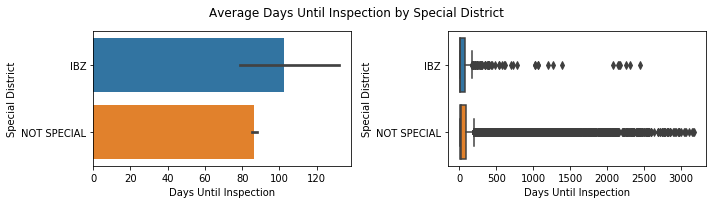

In [28]:
# Special District
aggregation_plots(db, "days_until_inspection", "special_district")

Not seeing much difference in average between Special Districts, however we do see a wide range in individual observations for "NOT SPECIAL" districts.

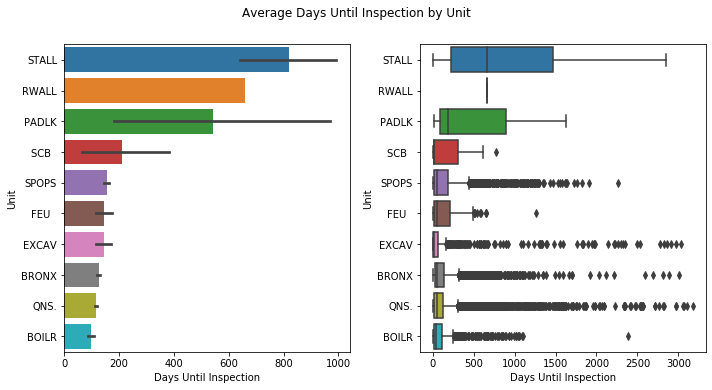

In [29]:
# Unit
aggregation_plots(db, "days_until_inspection", "unit")

The STALL and PADLK units appear to have the longest average days of inspection with little different between the other units. Thos other units, however, have much more extreme ranges.

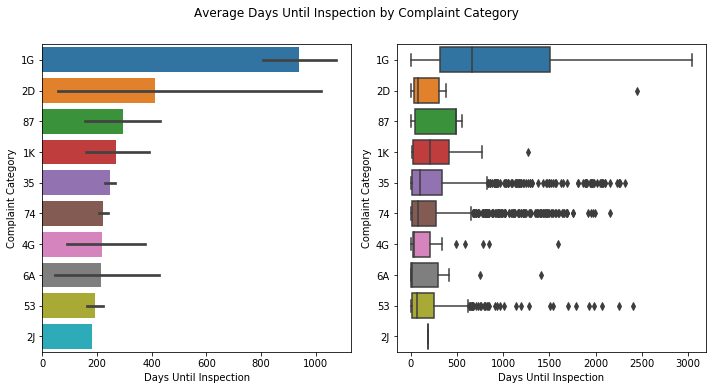

In [30]:
# Complaint Category
aggregation_plots(db, "days_until_inspection", "complaint_category")

The "1G" complaint category appears to take significantly longer to inspect than all other categories, even when taking into account the extreme ranges seen in those categories.

## General Linearized Model (GLM)

### Model Preparation for GLM

Before attempting a SARIMAX model, we'll first explore a general linearized model using the gamma distribution. The target variable, `days_until_inspecti,on`, is bound from $0$ to $\infty$ with an exponentially decreasing frequency.

https://www.statsmodels.org/dev/examples/notebooks/generated/glm.html#GLM:-Gamma-for-proportional-count-response

__Because only using categorical data, this GLM turns into an [ANOVA](https://www.statsmodels.org/dev/anova.html) model__

Therefore, will need to use formula version of GLM because the ANOVA implementation needs to know how categories were formed using the "formula notation" - [source](https://s3.amazonaws.com/assets.datacamp.com/production/course_15356/slides/chapter1.pdf)
- How to use formula notation - [link](https://www.statsmodels.org/dev/examples/notebooks/generated/glm_formula.html)



In [31]:
db.head()

,complaint_number,status,date_entered,house_number,zip_code,house_street,special_district,complaint_category,unit,inspection_date,days_until_inspection
1,2193181,CLOSED,2013-12-17,573,10458,EAST FORDHAM ROAD,NOT SPECIAL,4B,SEP,2013-12-24,7
6,1265849,CLOSED,2009-09-21,429,10075,EAST 77 STREET,NOT SPECIAL,73,MAN.,2009-10-03,12
12,1404696,CLOSED,2015-09-02,21,10011,WEST 8 STREET,NOT SPECIAL,37,ERT,2015-09-03,1
13,2149422,CLOSED,2010-08-25,2075,10462,WALLACE AVENUE,NOT SPECIAL,23,ERT,2010-10-09,45
14,3312533,CLOSED,2009-07-20,819,11220,59 STREET,NOT SPECIAL,90,CITY,2009-09-15,57


In [32]:
target = "days_until_inspection"
glm_features = ["special_district", "complaint_category", "unit", target]
glm_db = db[glm_features]

#### Creating `vizResids` function

`vizResids` is a convenience function to abstract the relevant regression-like model evaluation graphs:
1. True Values ($y$) vs. Predictions ($\hat{y}$)
2. Residuals Plot
3. Residuals Histogram

In [33]:
def vizResids(model_title, target_name,y_true, y_preds):
    resids = y_true - y_preds
    score = r2_score(y_true, y_preds)
    # HANDLING SUBPLOTS
    fig, axes = plt.subplots(2, 2, figsize=(12,10)) # 2 row x 2 columns
    fig.suptitle(f"{model_title}: $R^2$ ={score:2.2%}", fontsize = 24, y = 1.05)

    ax_1 = axes[0][0]
    ax_2 = axes[0][1]
    ax_3 = axes[1][0]

    subplot_title_size = 18
    subplot_label_size = 14
    
    # 1ST PLOT - y_true vs. y_pred
    ax_1.set_title("True Values ($y$) vs. Predictions ($\hat{y}$)", fontsize = subplot_title_size, pad = 10)
    maxDist = max(max(y_preds),max(y_true)) # maxiumum value used to determin x_lim and y_lim
    minDist = min(min(y_preds),min(y_true)) # maxiumum value used to determin x_lim and y_lim
    # 45deg line, signifying prediction == true value
    ax_1.plot((minDist,maxDist),(minDist,maxDist), c = "r", alpha = .7);
    
    sns.scatterplot(ax = ax_1, x = y_true, y = y_preds, alpha = .5)
    ax_1.set_xlabel("True Values ($y$)", fontsize = subplot_label_size, labelpad = 10)
    ax_1.set_ylabel("Predictions ($\hat{y}$)", fontsize = subplot_label_size, labelpad = 10)

    # 2ND PLOT - residuals
    ax_2.set_title("Residuals", fontsize = subplot_title_size)
    sns.scatterplot(ax = ax_2, x = range(len(resids)),y = resids, alpha = .5)
    ax_2.set_ylabel(target_name, fontsize = subplot_label_size)
    ax_2.axhline(0, c = "r", alpha = .7);

    # 3RD PLOT - residuals histogram
    ax_3.set_title("Histogram of residuals", fontsize = subplot_title_size)
    sns.distplot(resids, ax = ax_3, kde = False);
    ax_3.set_xlabel(target_name, fontsize = subplot_label_size)
    ax_3.set_ylabel("Frequency", fontsize = subplot_label_size)

    plt.tight_layout() # handles most overlaping and spacing issues

### Modeling GLM

In [34]:
glm_gamma = smf.glm(
    formula = "days_until_inspection ~ C(special_district) + C(complaint_category) + C(unit)",
    data = glm_db,
    family = sm.families.Gamma(link = sm.families.links.identity)
).fit()

In [35]:
glm_gamma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                   
=================================================================================
Dep. Variable:     days_until_inspection   No. Observations:                82123
Model:                               GLM   Df Residuals:                    81996
Model Family:                      Gamma   Df Model:                          126
Link Function:                  identity   Scale:                          13.437
Method:                             IRLS   Log-Likelihood:            -4.8830e+05
Date:                   Tue, 11 Feb 2020   Deviance:                   2.0696e+05
Time:                           18:54:03   Pearson chi2:                 1.10e+06
No. Iterations:                      100                                         
Covariance Type:               nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                            189.5271     35.704      5.308      0.000     119.549     259.506
C(special_district)[T.NOT SPECIAL]   -19.4644      8.112     -2.400      0.016     -35.363      -3.566
C(complaint_category)[T.03]         -140.6805     34.823     -4.040      0.000    -208.932     -72.429
C(complaint_category)[T.04]         -136.6312     34.833     -3.922      0.000    -204.903     -68.359
C(complaint_category)[T.05]          -74.0716     34.922     -2.121      0.034    -142.517      -5.626
C(complaint_category)[T.06]          -94.3109     38.075     -2.477      0.013    -168.937     -19.685
C(complaint_category)[T.09]         -103.2218     35.606     -2.899      0.004    -173.008     -33.435
C(complaint_category)[T.10]         -136.4546     34.918     -3.908      0.000    -204.893     -68.017
C(complaint_category)[T.12]         -101.6053     38.797     -2.619      0.009    -177.646     -25.565
C(complaint_category)[T.14]          -87.0336     39.756     -2.189      0.029    -164.954      -9.113
C(complaint_category)[T.15]          -99.8707     35.509     -2.813      0.005    -169.467     -30.274
C(complaint_category)[T.16]         -148.4674     35.364     -4.198      0.000    -217.779     -79.156
C(complaint_category)[T.18]         -139.1992     37.860     -3.677      0.000    -213.403     -64.996
C(complaint_category)[T.1A]          -78.7335     40.246     -1.956      0.050    -157.613       0.146
C(complaint_category)[T.1B]         -131.3412     36.294     -3.619      0.000    -202.476     -60.206
C(complaint_category)[T.1C]         -146.2611     35.579     -4.111      0.000    -215.994     -76.529
C(complaint_category)[T.1D]         -112.5486     41.900     -2.686      0.007    -194.672     -30.426
C(complaint_category)[T.1E]         -135.5371     36.969     -3.666      0.000    -207.995     -63.079
C(complaint_category)[T.1G]          791.3972    295.286      2.680      0.007     212.647    1370.148
C(complaint_category)[T.1J]         -145.0328     63.722     -2.276      0.023    -269.926     -20.139
C(complaint_category)[T.1K]           45.8077    196.838      0.233      0.816    -339.988     431.604
C(complaint_category)[T.1L]         -133.8458     35.678     -3.751      0.000    -203.774     -63.918
C(complaint_category)[T.1X]         -146.1966     35.012     -4.176      0.000    -214.818     -77.575
C(complaint_category)[T.1Y]         -178.9647     36.897     -4.850      0.000    -251.282    -106.647
C(complaint_category)[T.1Z]         -137.2443     35.273     -3.891      0.000    -206.379     -68.110
C(complaint_category)[T.20]         -106.2936     34.778     -3.056      0.002    -174.458     -38.130
C(complaint_category)[T.21]          -91.8949     38.077     -2

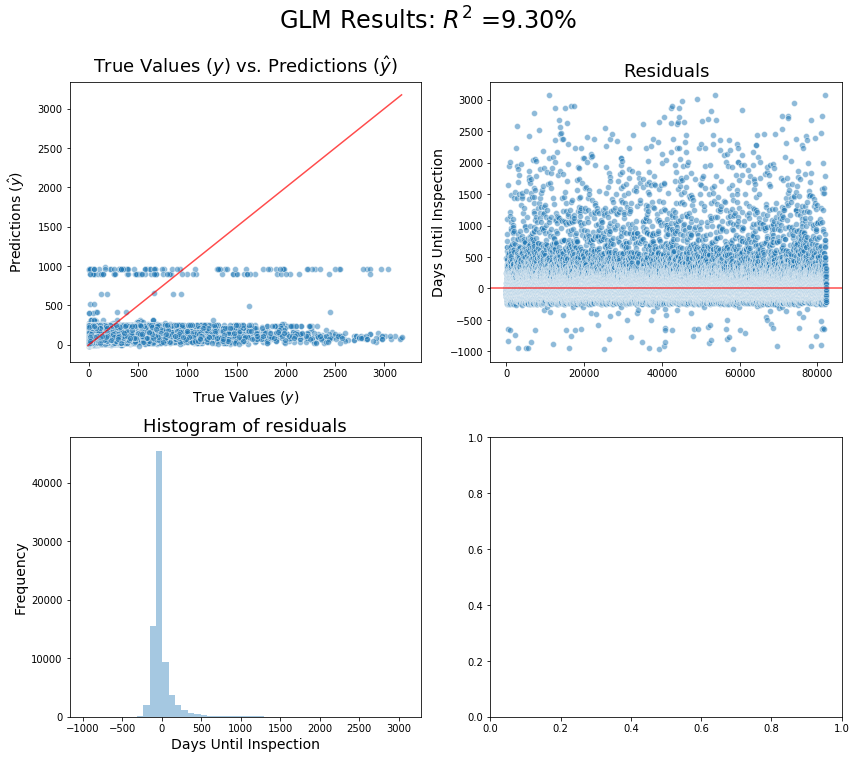

In [36]:
vizResids("GLM Results", "Days Until Inspection", glm_db[target], glm_gamma.predict(glm_db))

The GLM model does a poor job of capturing the variance in the model. Much of the failings of this model is likely due to the fact that all of the features are categorical, turning this linear model into something akin to an ANOVA.

According to the summary, almost all of the categorical dummy features are likely insignificant and may suggest our data severely lacks correlation with our target variable. 

## SARIMAX
We've alread seen some seasonality components in our data, which is a motivating reason for exploring a SARIMAX model.

### Model Preparation for SARIMAX

In [37]:
# ARIMA SETUP
arima_db = db_with_time_index.resample("D").sum().dropna().sort_index()

# EXOGENOUS VARIABLE
sarimax_features = ["special_district","complaint_category","unit"]
exog = pd.get_dummies(db.set_index("date_entered")[sarimax_features]).resample("D").sum().dropna().sort_index()

#### Determining `d` using ADF (Augmented Dickey Fuller) Test

In [38]:
result = adfuller(arima_db[target])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.053833
p-value: 0.001153
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


With a confidence of 95%, we reject the hypothesis the data has no stationarity, therefore we must conclude the data already has stationarity. 

We will not need to difference (`d = 0`).

#### Determining `p` using autocorrelation function

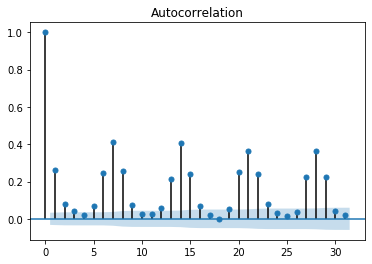

In [39]:
plot_acf(arima_db[target], lags=31)
plt.show()

We find the first positive auto correlation lag is `p = 1`.

#### Determining `q` using partial-autocorrelation function

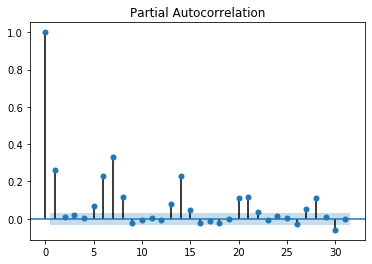

In [40]:
plot_pacf(arima_db[target], lags=31)
plt.show()

The first positive partial-autocorrelation lag is `q = 1`

#### Determining `S`, seasonal component

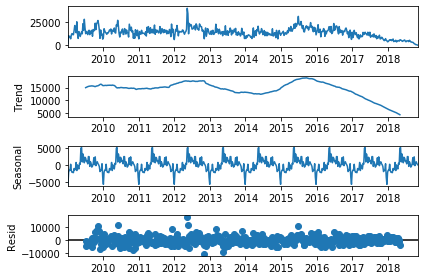

In [41]:
seasonal_decompose(db_time_by_week).plot()
plt.show()

We find a strong weekly seasonal component, we'll be using `S = 7`

In [42]:
# ARIMA
p, d, q = (1, 0, 1)

# seasonal order
P, D, Q, S = (1, 0, 1, 7)

### Modeling SARIMAX

In [43]:
sarima = SARIMAX(endog = arima_db.values,
                 order = (p, d, q),
                 seasonal_order = (P, D, Q, S),
                 exog = exog.values
                )

fitted_sarima = sarima.fit()

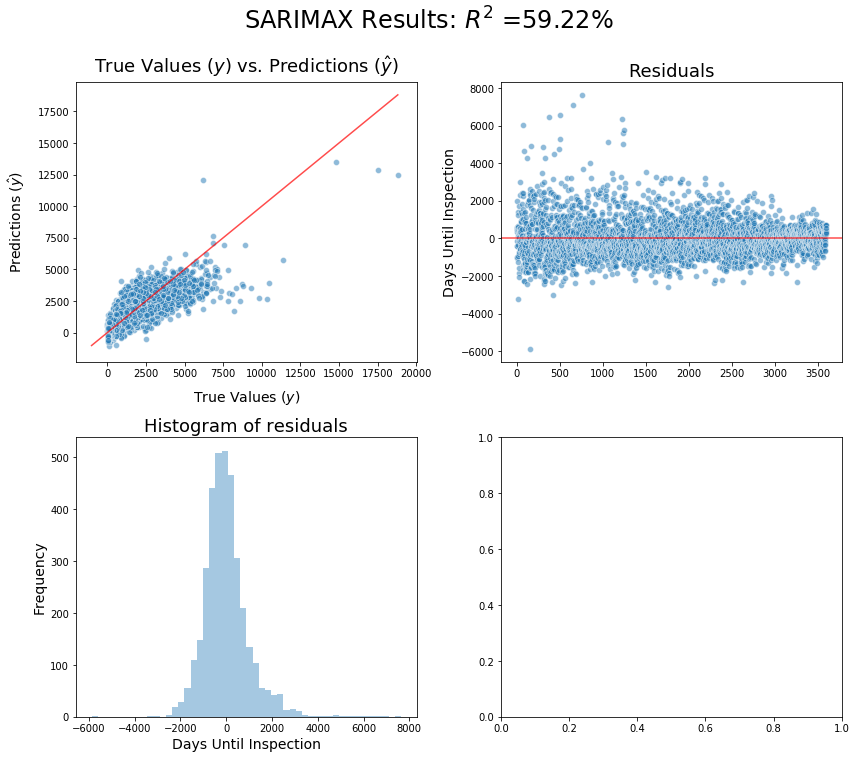

In [44]:
vizResids("SARIMAX Results", "Days Until Inspection", arima_db[target], fitted_sarima.predict(start=0,end=-1))

In [45]:
from sklearn.metrics import mean_squared_error

In [46]:
preds = fitted_sarima.predict(start=0,end=-1)

In [49]:
rmse = mean_squared_error(arima_db[target], preds) ** .5

In [54]:
rmse / 30 / 12

2.744607787556756

Using RMSE, we can see the model is off, on average, by about 2.7 YEARS!

## Classification Model
By converting target into classes, can simplify model and increase performance

## Model Selection

## Model Evaluation

## Conclusion

## Recommendations

## Resources
- [Data Source](https://data.cityofnewyork.us/Housing-Development/DOB-Complaints-Received/eabe-havv)
- [Complaint Codes](https://www1.nyc.gov/assets/buildings/pdf/complaint_category.pdf)
- [Disposition Codes](https://www1.nyc.gov/assets/buildings/pdf/bis_complaint_disposition_codes.pdf)
- [Data Explains](https://docs.google.com/spreadsheets/d/10p0HLqinKbUrSjKaZC2E0ZTHDXgULT0K/edit#gid=1015257717)